### EDA and Forecasting of Superstore Sales

This project...

#### Library imports and necessary pip installs

In [134]:
!pip install kagglehub --q
!pip install seaborn   --q


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [135]:
import kagglehub
import shutil
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Dataset download

We download the dataset we'll be using from kaggle using the `kagglehub` library

In [116]:
path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

Since this method by default downloads files to an internal KaggleHub cache location, we'll copy them to our current location. 

In [117]:
destination = os.path.join(os.getcwd(), "./data")
os.makedirs(destination, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(destination, filename)
    shutil.copy(src_file, dst_file)

We now read the dataset with `pandas` and we can take a look and start exploring the different fields.

In [145]:
df = pd.read_csv(os.path.join(destination, "train.csv"))
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


#### Exploratory Data Analysis

We'll drop some irrelevant or low-impact columns for sales forecasting. These include identifiers and granular personal data that do not contribute significantly to the forecasting task.

We'll also convert the format of `Order Date` and `Ship Date` to standard datetime formats.

In [146]:
columns_to_drop = [
    'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
    'Customer Name', 'Product ID', 'Postal Code', 'Country'
    ]

df.drop(columns=columns_to_drop, inplace=True)

df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")
df['Ship Date']  = pd.to_datetime(df['Ship Date'], format="%d/%m/%Y")

In [147]:
df.head(5)

,Order Date,Ship Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales
0,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,2017-06-12,2017-06-16,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


We will create separate datasets for each region to identify the sales trends on each (if any).

In [148]:
central = df[df['Region'] == 'Central']
east    = df[df['Region'] == 'East']
south   = df[df['Region'] == 'South']
west    = df[df['Region'] == 'West']

We now make the necessary convertions so we have an overall monthly sales df and also by region monthly sales df.

To achieve this we group `Sales` by `Order Date`, then sort according to `Order Date` and finally resample this same column so it's in year-month format.

In [152]:
all_daily   = df.groupby('Order Date')['Sales'].sum().reset_index()
all_daily   = all_daily.sort_values('Order Date')
all_monthly = all_daily.set_index('Order Date').resample('ME').mean()

central_daily   = central.groupby('Order Date')['Sales'].sum().reset_index()
central_daily   = central_daily.sort_values('Order Date')
central_monthly = central_daily.set_index('Order Date').resample('ME').mean()

east_daily   = east.groupby('Order Date')['Sales'].sum().reset_index()
east_daily   = east_daily.sort_values('Order Date')
east_monthly = east_daily.set_index('Order Date').resample('ME').mean()

south_daily   = south.groupby('Order Date')['Sales'].sum().reset_index()
south_daily   = south_daily.sort_values('Order Date')
south_monthly = south_daily.set_index('Order Date').resample('ME').mean()

west_daily   = west.groupby('Order Date')['Sales'].sum().reset_index()
west_daily   = west_daily.sort_values('Order Date')
west_monthly = west_daily.set_index('Order Date').resample('ME').mean()

We plot figures to see the overall sales over time, and the sales-per-region over time.

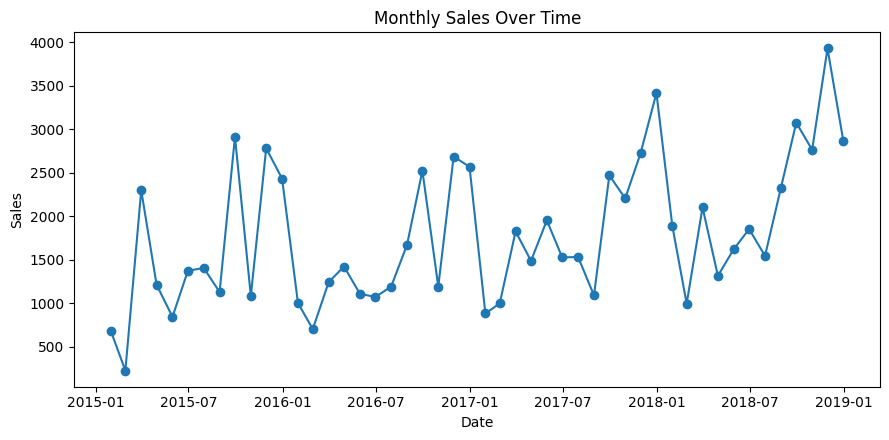

In [154]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_monthly.index, all_monthly['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

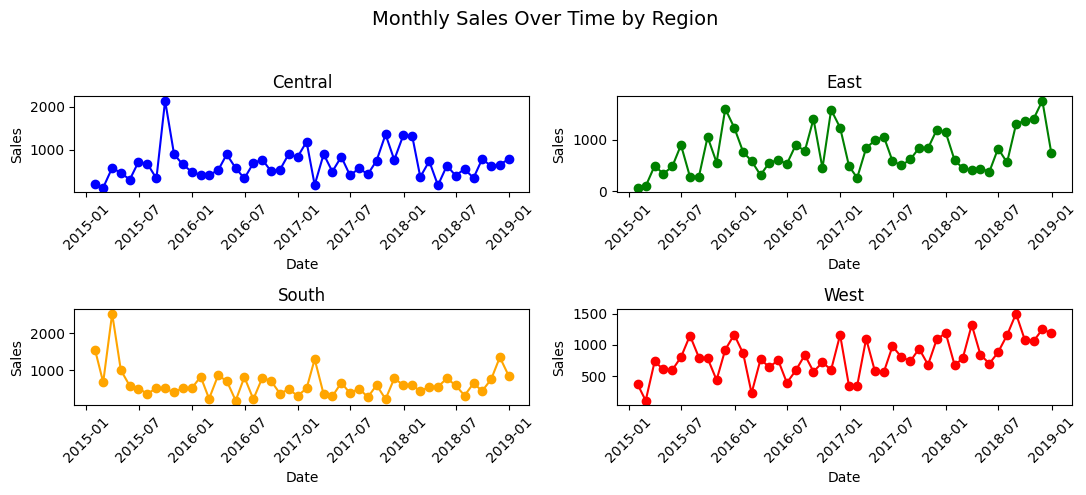

In [165]:
fig, axs = plt.subplots(2, 2, figsize=(11, 5))
fig.suptitle('Monthly Sales Over Time by Region', fontsize=14)

axs[0, 0].plot(central_monthly.index, central_monthly['Sales'], color='blue', marker='o')
axs[0, 0].set_title('Central')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Sales')

axs[0, 1].plot(east_monthly.index, east_monthly['Sales'], color='green', marker='o')
axs[0, 1].set_title('East')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Sales')

axs[1, 0].plot(south_monthly.index, south_monthly['Sales'], color='orange', marker='o')
axs[1, 0].set_title('South')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Sales')

axs[1, 1].plot(west_monthly.index, west_monthly['Sales'], color='red', marker='o')
axs[1, 1].set_title('West')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Sales')

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()